Import all libraries


In [ ]:
%pip install -U -q pandas
%pip install -U -q matplotlib

In [203]:
import os
import zipfile
import shutil
import re
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.stats import linregress

# INMET Data Treatment

Extract INMET files


In [52]:
inmet_zip_folder = './Data/Inmet/zips'
inmet_extract_folder = './Data/Inmet/extracted'
datasus_folder = './Data/DataSUS - SP'
inmetDF = pd.DataFrame()
dataSUSDF = pd.DataFrame()

In [44]:
if not os.path.exists(inmet_extract_folder):
    os.makedirs(inmet_extract_folder)

zip_files = os.listdir(inmet_zip_folder)

for zip_file in zip_files:
    zip_path = os.path.join(inmet_zip_folder, zip_file)
    folder_name = os.path.splitext(zip_file)[0]
    folder_path = os.path.join(inmet_extract_folder, folder_name)

    if zipfile.is_zipfile(zip_path):  # Check if the file is a valid zip file
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(folder_path)

print('Extraction done!')

Extraction done!


Organize folder and files from INMET


In [45]:
def move_files_to_root_folder(current_folder, root_folder=None):
    objects = os.listdir(current_folder)
    for object in objects:
        object_path = os.path.join(current_folder, object)
        if os.path.isdir(object_path):
            move_files_to_root_folder(object_path, os.path.join(
                current_folder, object) if root_folder == None else root_folder)
            if len(os.listdir(object_path)) == 0:
                os.rmdir(object_path)
        else:
            shutil.move(object_path, os.path.join(root_folder, object))


move_files_to_root_folder(inmet_extract_folder)
print('Path organized!')

Path organized!


Create Pandas DF to analyse data from SP


In [ ]:
def renameColumns(df):
    df.rename(columns={
        'DATA (YYYY-MM-DD)': 'data',
        'Data': 'data',
        'Hora UTC': 'hora_utc',
        'HORA (UTC)': 'hora_utc',
        'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)': 'precipitacao_mm',
        'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)': 'pressao_atm_mb',
        'PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)': 'pressao_atm_max_mb',
        'PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)': 'pressao_atm_min_mb',
        'RADIACAO GLOBAL (KJ/m²)': 'radiacao_global_kj_m2',
        'RADIACAO GLOBAL (Kj/m²)': 'radiacao_global_kj_m2',
        'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)': 'temp_ar_bulbo_seco_c',
        'TEMPERATURA DO PONTO DE ORVALHO (°C)': 'temp_ponto_orvalho_c',
        'TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)': 'temp_max_c',
        'TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)': 'temp_min_c',
        'TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C)': 'temp_orvalho_max_c',
        'TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C)': 'temo_orvalho_min_c',
        'UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)': 'umidade_rel_max',
        'UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)': 'umidade_rel_min',
        'UMIDADE RELATIVA DO AR, HORARIA (%)': 'umidade_rel_ar_percent',
        'VENTO, DIREÇÃO HORARIA (gr) (° (gr))': 'vento_direcao_graus',
        'VENTO, RAJADA MAXIMA (m/s)': 'vento_rajada_max_m_s',
        'VENTO, VELOCIDADE HORARIA (m/s)': 'vento_velocidade_horaria_m_s',
    }, inplace=True)

    return df


def getCSVFiles(path):
    df = pd.DataFrame()
    for file in os.listdir(path):
        file_path = os.path.join(path, file)
        if os.path.isdir(file_path):
            df = pd.concat([df, getCSVFiles(file_path)])
        else:
            pattern = r"\w+_\w+_(?P<state>\w+)_\w+_(?P<city_name>.*)_\d{2}-\d{2}-\d{4}_A_\d{2}-\d{2}-\d{4}.csv"
            match = re.match(pattern, file, re.IGNORECASE)
            if match:
                city_name = match.group('city_name').lower()

                if match.group('state') == "SP" and "sao paulo" in city_name:
                    if "sao paulo" in city_name.lower():
                        auxDF = pd.read_csv(
                            file_path, skiprows=8, delimiter=';', encoding='latin1', decimal=',')

                        if "Data" in auxDF.columns:
                            auxDF['Hora UTC'] = auxDF['Hora UTC'].replace(
                                ' UTC', '', regex=True)
                            auxDF['Data'] = pd.to_datetime(
                                (auxDF['Data'] + ' ' + auxDF['Hora UTC']), format='%Y/%m/%d %H%M', utc=True, errors='coerce')

                        if "DATA (YYYY-MM-DD)" in auxDF.columns:
                            auxDF['DATA (YYYY-MM-DD)'] = pd.to_datetime(
                                (auxDF['DATA (YYYY-MM-DD)'] + ' ' + auxDF['HORA (UTC)']), format='%Y-%m-%d %H:%M', utc=True, errors='coerce')

                        auxDF = renameColumns(auxDF)
                        auxDF.drop(columns=auxDF.columns[-1], inplace=True)
                        auxDF.drop(columns='hora_utc', inplace=True)
                        df = pd.concat([df, auxDF])
    return df


inmetDF = getCSVFiles(inmet_extract_folder)
print('INMET data loaded!')

In [170]:
if not os.path.exists('./Data/etl_output'):
    os.makedirs('./Data/etl_output')
inmetDF.to_csv('./Data/etl_output/INMET_SP.csv',
               index=False, encoding='utf-8', sep=';')

# DATASUS Data Treatment

In [ ]:
def getSUSCSVFiles(path):
    df = pd.DataFrame({})
    for file in os.listdir(path):
        file_year = None
        file_path = os.path.join(path, file)
        with open(file_path, 'r', encoding='latin1') as doc:
            for current_line_number, line in enumerate(doc, start=1):
                if current_line_number == 5:
                    file_year = line.strip().split(':')[1]
                    break
        auxDF = pd.read_csv(file_path, skiprows=5, delimiter=';', encoding='latin1', decimal='.')
        auxDF = auxDF.rename(columns={
            'Município de residência': 'municipio',
            'Ign/Em Branco': 'ign_em_branco',
            "Fev": 'Feb',
            "Abr": 'Apr',
            "Mai": 'May',
            "Ago": 'Aug',
            "Set": 'Sep',
            "Out": 'Oct',
            "Dez": 'Dec'
        })

        new_row = auxDF[auxDF['municipio'] == '355030 SAO PAULO']
        new_row.insert(0, 'year', file_year)
        df = pd.concat([df, new_row], ignore_index=True)

    return df

dataSUSDF = getSUSCSVFiles(datasus_folder)

print(dataSUSDF.columns.tolist())

Creating Pivoted Dataframe to be plotted in the future

In [404]:
df_melted = pd.melt(dataSUSDF, id_vars=[
                    'year', 'municipio'], var_name='month', value_name='value')

df_melted = df_melted[df_melted['month'] != 'ign_em_branco']
df_melted = df_melted[df_melted['month'] != 'Total']

# Concatenate 'month' and 'year' columns to create new column names
df_melted['month_year'] = df_melted['month'] + \
    '/' + df_melted['year'].astype(str)

# Drop unnecessary columns
df_melted.drop(['year', 'month'], axis=1, inplace=True)

# Pivot the DataFrame to get the desired format
df_pivoted = df_melted.pivot_table(
    index=['municipio', 'month_year'], columns=None, values='value', aggfunc='sum').reset_index()
df_pivoted = df_pivoted.iloc[:-1]
df_pivoted['value'] = pd.to_numeric(df_pivoted['value'])
df_pivoted['month_year'] = pd.to_datetime(df_pivoted['month_year'], format='%b/%Y')
df_pivoted = df_pivoted[~(df_pivoted['month_year'] > '2024-03')]
df_pivoted = df_pivoted.sort_values(by='month_year').reset_index(drop=True)
# df_pivoted = df_pivoted.iloc[:-3].reset_index(drop=True)

df_pivoted_x = range(len(df_pivoted))
df_pivoted_slope, df_pivoted_intercept, r_value, p_value, std_err = linregress(df_pivoted_x, df_pivoted['value'])

# Calculate the regression line
df_pivoted['linear_regression'] = [df_pivoted_slope * i + df_pivoted_intercept for i in df_pivoted_x]
max_cases = df_pivoted['value'].max()
min_cases = df_pivoted['value'].min()
df_pivoted['cases_normalized'] = ((df_pivoted['value'] - min_cases) / (max_cases - min_cases)) * 100


linear_slope, linear_intercept, r_value, p_value, std_err = linregress(range(len(df_pivoted)), df_pivoted['cases_normalized'])
df_pivoted['normalized_linear_regression'] = [linear_slope * i + linear_intercept for i in range(len(df_pivoted))]

print(df_pivoted.head(5))
print(df_pivoted.tail(5))



          municipio month_year  value  linear_regression  cases_normalized  \
0  355030 SAO PAULO 2014-01-01    244         187.436008          0.200054   
1  355030 SAO PAULO 2014-02-01    885         228.685425          0.745735   
2  355030 SAO PAULO 2014-03-01   5240         269.934841          4.453128   
3  355030 SAO PAULO 2014-04-01  15895         311.184257         13.523683   
4  355030 SAO PAULO 2014-05-01   8722         352.433674          7.417339   

   normalized_linear_regression  
0                      0.151902  
1                      0.187017  
2                      0.222133  
3                      0.257248  
4                      0.292364  
            municipio month_year   value  linear_regression  cases_normalized  \
118  355030 SAO PAULO 2023-11-01     478        5054.867139          0.399258   
119  355030 SAO PAULO 2023-12-01     866        5096.116556          0.729560   
120  355030 SAO PAULO 2024-01-01    8672        5137.365972          7.374774   
121

Creating final INMET Dataframe formated to be plotted in the future

In [407]:
inmetPlotDF = inmetDF.copy()

inmetPlotDF['data'] = pd.to_datetime(inmetPlotDF['data'], utc=True)
# inmetPlotDF = inmetPlotDF[~(inmetPlotDF['data'] > '2024-03')]
# Extract date from datetime
inmetPlotDF['data'] = inmetPlotDF['data'].dt.to_period('M')

# Group by date and get the maximum temp_max_c for each date
inmetPlotDF = inmetPlotDF.groupby('data')['temp_max_c'].max().reset_index()
inmetPlotDF = inmetPlotDF.sort_values(by='data')
condition = inmetPlotDF['temp_max_c'] < -900
inmetPlotDF = inmetPlotDF[~condition]
inmetPlotDF = inmetPlotDF.iloc[:-3].reset_index(drop=True)
inmetPlotDF['moving_avg'] = inmetPlotDF['temp_max_c'].rolling(window=6).mean()
max_temp = inmetPlotDF['temp_max_c'].max()
min_temp = inmetPlotDF['temp_max_c'].min()

min_temp_moving_avg = inmetPlotDF['moving_avg'].min()
max_temp_moving_avg = inmetPlotDF['moving_avg'].max()

inmetPlotDF['temp_normalized'] = (
    (inmetPlotDF['temp_max_c'] - min_temp) / (max_temp-min_temp)) * 100


inmetPlotDF['normalized_moving_avg'] = (
    (inmetPlotDF['moving_avg'] - min_temp_moving_avg) / (max_temp_moving_avg - min_temp_moving_avg)) * 100

slope, intercept, r_value, p_value, std_err = linregress(range(len(inmetPlotDF)), inmetPlotDF['temp_max_c'])

inmetPlotDF['linear_regression'] = [slope * i + intercept for i in range(len(inmetPlotDF))]

linear_slope, linear_intercept, r_value, p_value, std_err = linregress(range(len(inmetPlotDF)), inmetPlotDF['temp_normalized'])
inmetPlotDF['normalized_linear_regression'] = [linear_slope * i + linear_intercept for i in range(len(inmetPlotDF))]

# Display the new DataFrame
print(inmetPlotDF.head(5))
print(inmetPlotDF.tail(5))

      data  temp_max_c  moving_avg  temp_normalized  normalized_moving_avg  \
0  2014-01        35.6         NaN        77.692308                    NaN   
1  2014-02        36.5         NaN        84.615385                    NaN   
2  2014-03        33.4         NaN        60.769231                    NaN   
3  2014-04        32.0         NaN        50.000000                    NaN   
4  2014-05        27.8         NaN        17.692308                    NaN   

   linear_regression  normalized_linear_regression  
0          31.985482                     49.888324  
1          31.990698                     49.928447  
2          31.995914                     49.968570  
3          32.001130                     50.008693  
4          32.006346                     50.048816  
        data  temp_max_c  moving_avg  temp_normalized  normalized_moving_avg  \
115  2023-08        33.6   30.466667        62.307692              20.414201   
116  2023-09        36.9   31.150000        87.692308

/var/folders/fv/w0s5yhgj01307d4jlzql_7x80000gn/T/ipykernel_37148/237493363.py:6: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  inmetPlotDF['data'] = inmetPlotDF['data'].dt.to_period('M')


# Plotting Charts

## Plotting DataSUS

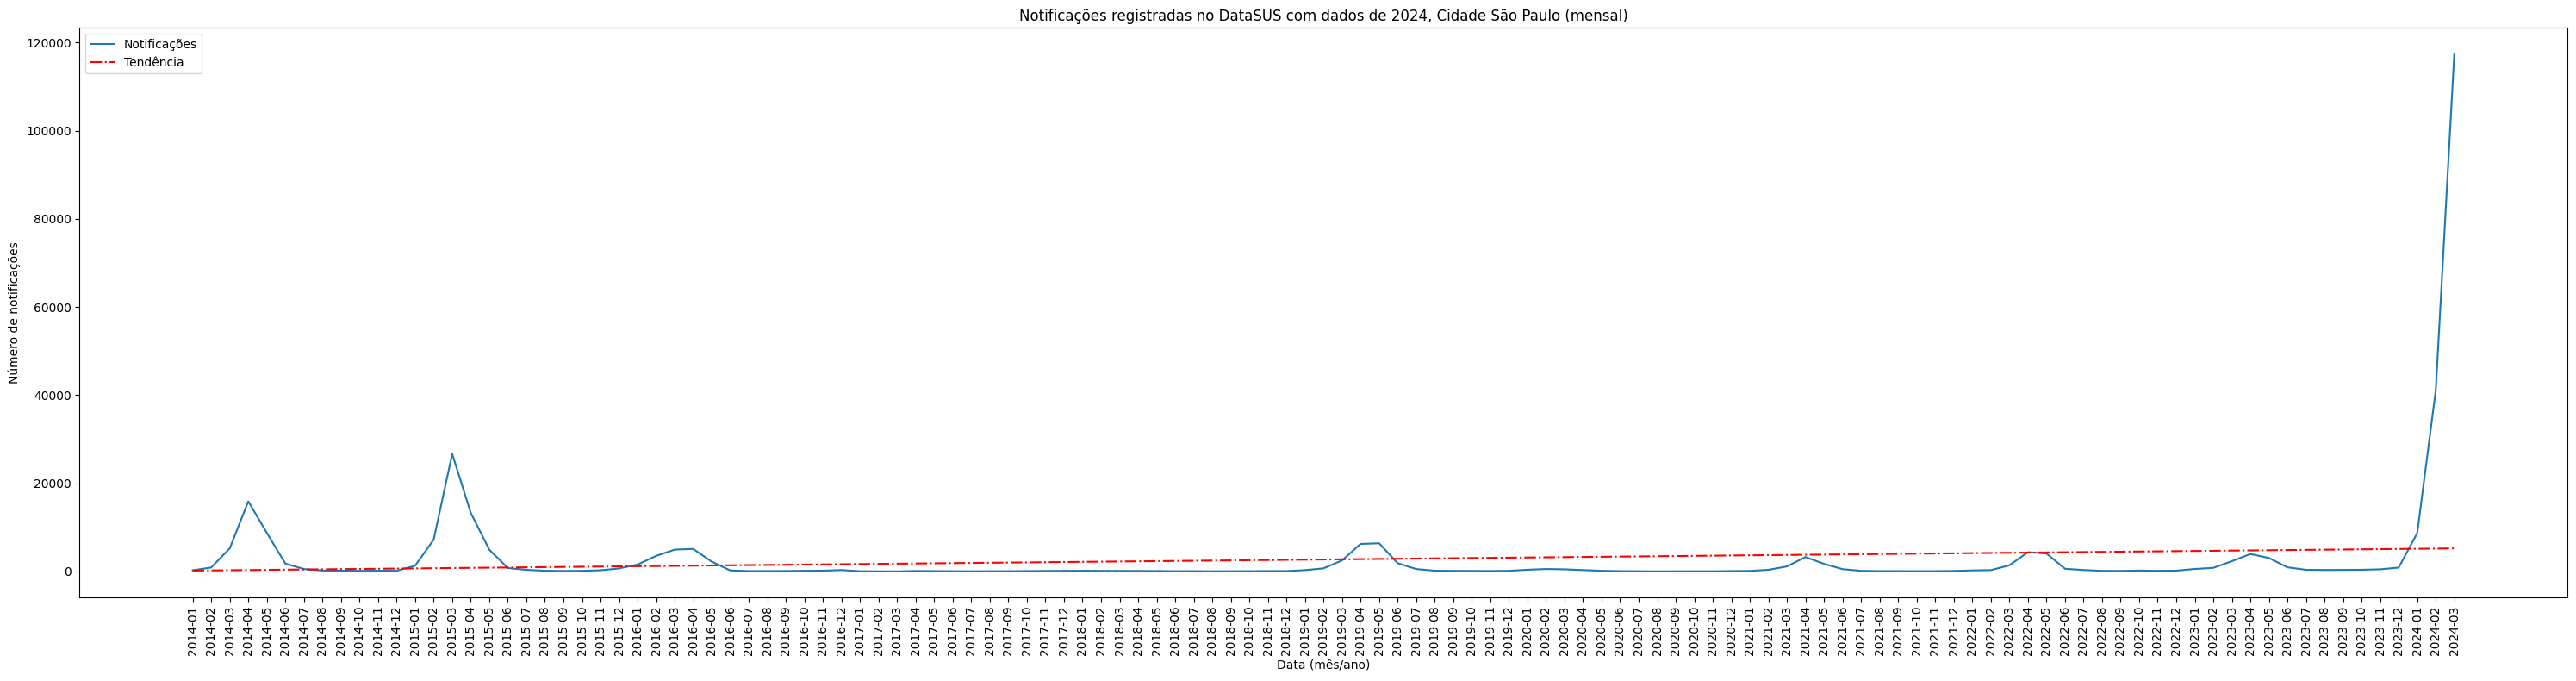

In [406]:
plt.figure(figsize=(30, 8))
plt.title('Notificações registradas no DataSUS com dados de 2024, Cidade São Paulo (mensal)')
plt.xlabel('Data (mês/ano)')
plt.ylabel('Número de notificações')
plt.xticks(rotation=90)
plt.plot(df_pivoted['month_year'].dt.to_period('M').astype(str), df_pivoted['value'], label='Notificações')
plt.plot(df_pivoted['month_year'].dt.to_period('M').astype(str), df_pivoted['linear_regression'], color='red', label='Tendência', linestyle='-.')
plt.legend()
plt.tight_layout()




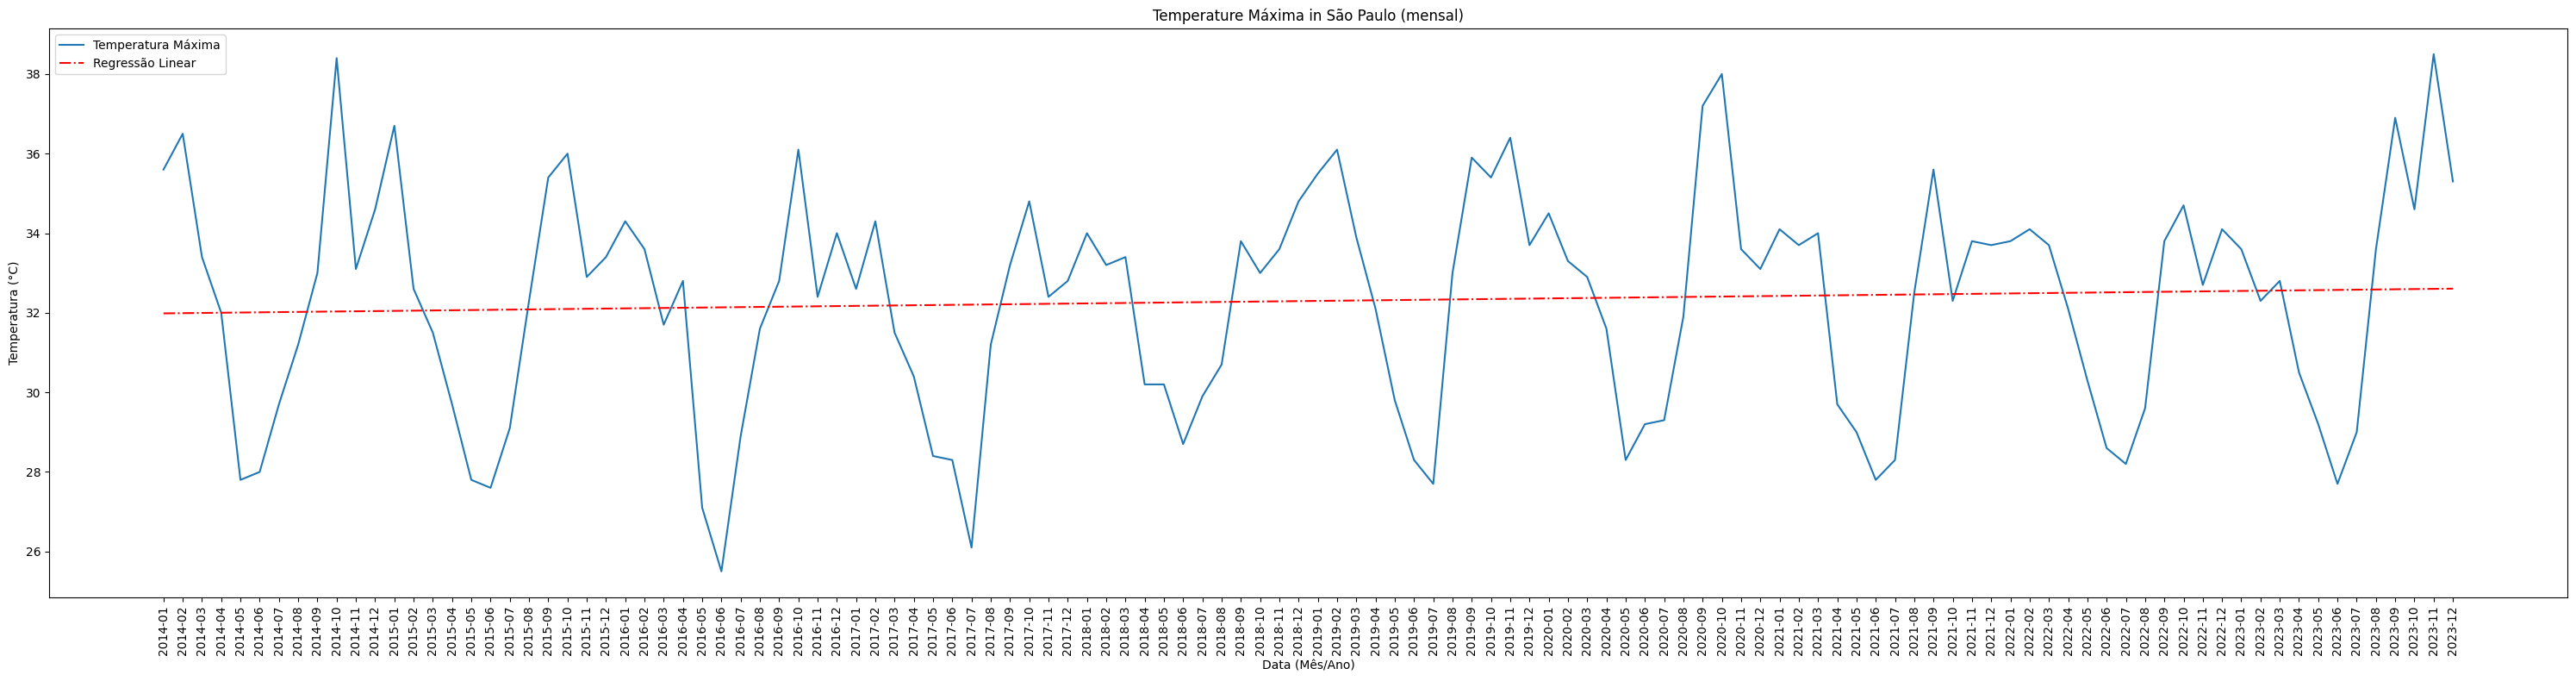

In [381]:
plt.figure(figsize=(30, 8))

plt.plot(inmetPlotDF['data'].astype(str), pd.to_numeric(inmetPlotDF['temp_max_c']), label='Temperatura Máxima')
# plt.plot(inmetPlotDF['data'].astype(str), inmetPlotDF['moving_avg'], label='6-Month Moving Average', color='red', linestyle='--')
plt.plot(inmetPlotDF['data'].astype(str), inmetPlotDF['linear_regression'], label='Regressão Linear', color='red', linestyle='-.')
plt.xlabel('Data (Mês/Ano)')
plt.ylabel('Temperatura (°C)')
plt.title('Temperature Máxima in São Paulo (mensal)')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

Percentage comparison DataSUS and INMET

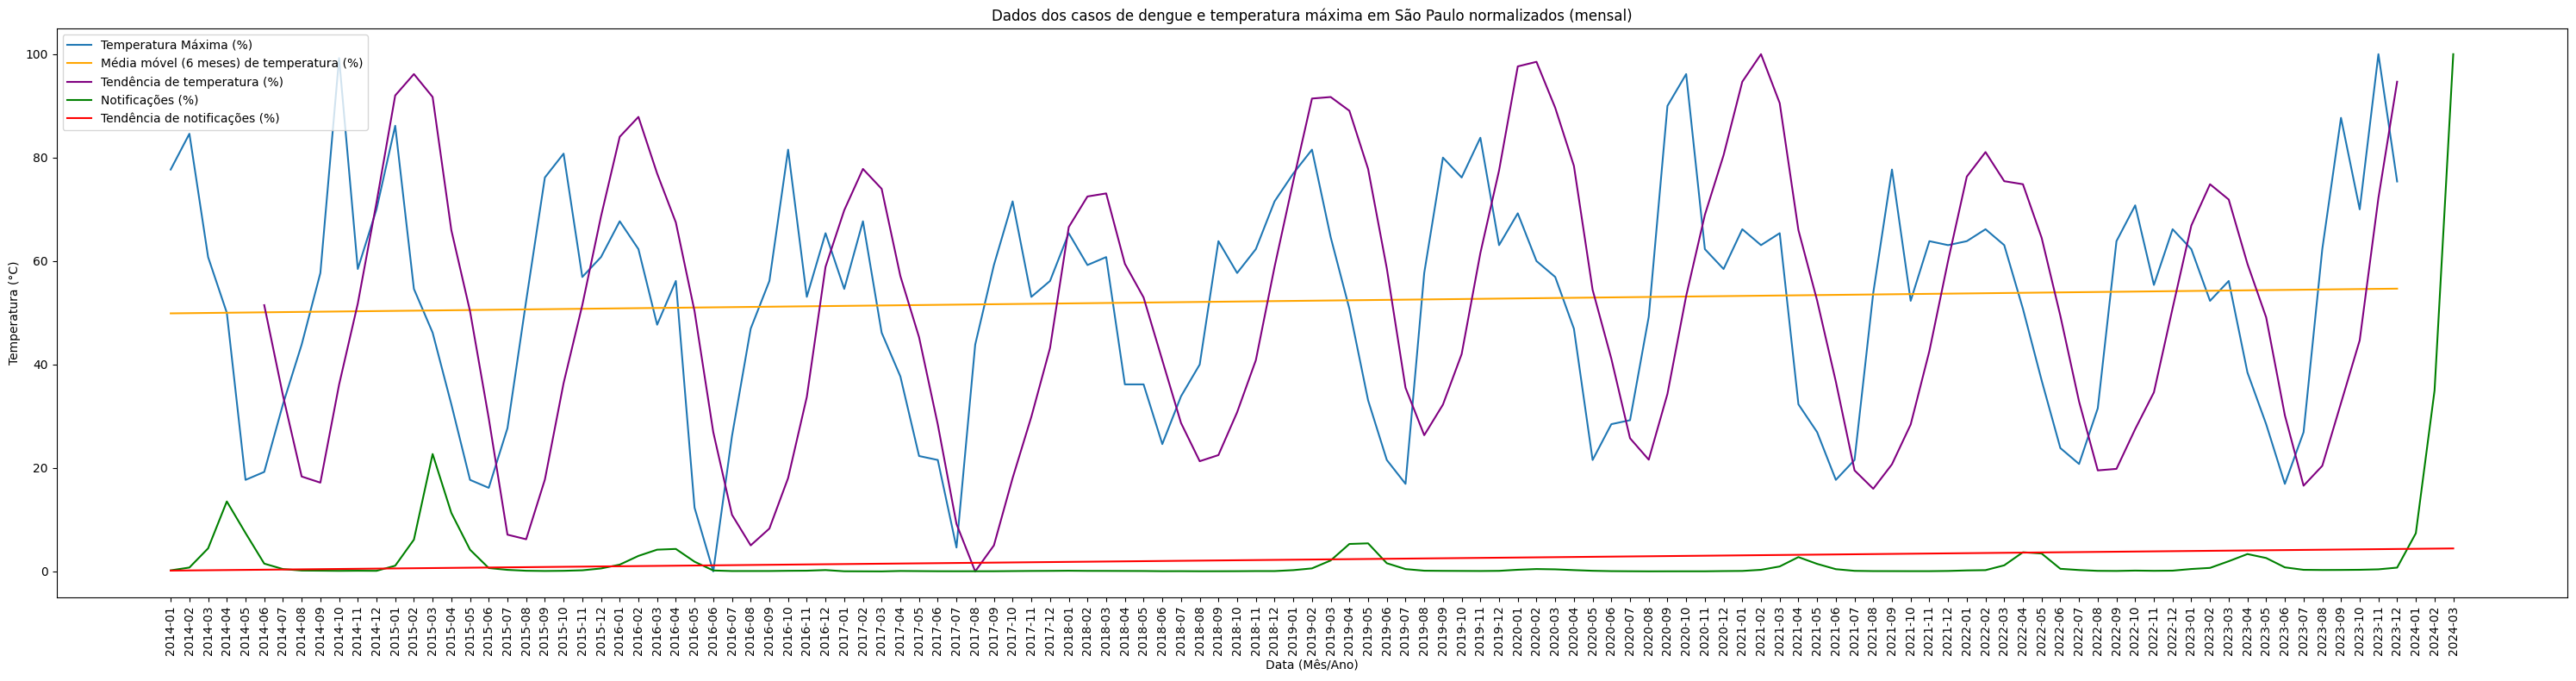

In [415]:
plt.figure(figsize=(30, 8))

plt.plot(inmetPlotDF['data'].astype(str), inmetPlotDF['temp_normalized'], label='Temperatura Máxima (%)')
plt.plot(inmetPlotDF['data'].astype(str), inmetPlotDF['normalized_linear_regression'], color='orange', label='Média móvel (6 meses) de temperatura (%)')
plt.plot(inmetPlotDF['data'].astype(str), inmetPlotDF['normalized_moving_avg'], color='purple', label='Tendência de temperatura (%)')
plt.plot((df_pivoted['month_year'].dt.to_period('M')).astype(str), df_pivoted['cases_normalized'], color='green', label='Notificações (%)')
plt.plot((df_pivoted['month_year'].dt.to_period('M')).astype(str), df_pivoted['normalized_linear_regression'], color='red', label='Tendência de notificações (%)')
plt.xticks(rotation=90)
plt.xlabel('Data (Mês/Ano)')
plt.ylabel('Temperatura (°C)')
plt.title('Dados dos casos de dengue e temperatura máxima em São Paulo normalizados (mensal)')
plt.legend()
plt.tight_layout()
plt.show()

Percentage comparison DataSUS and INMET cleanned

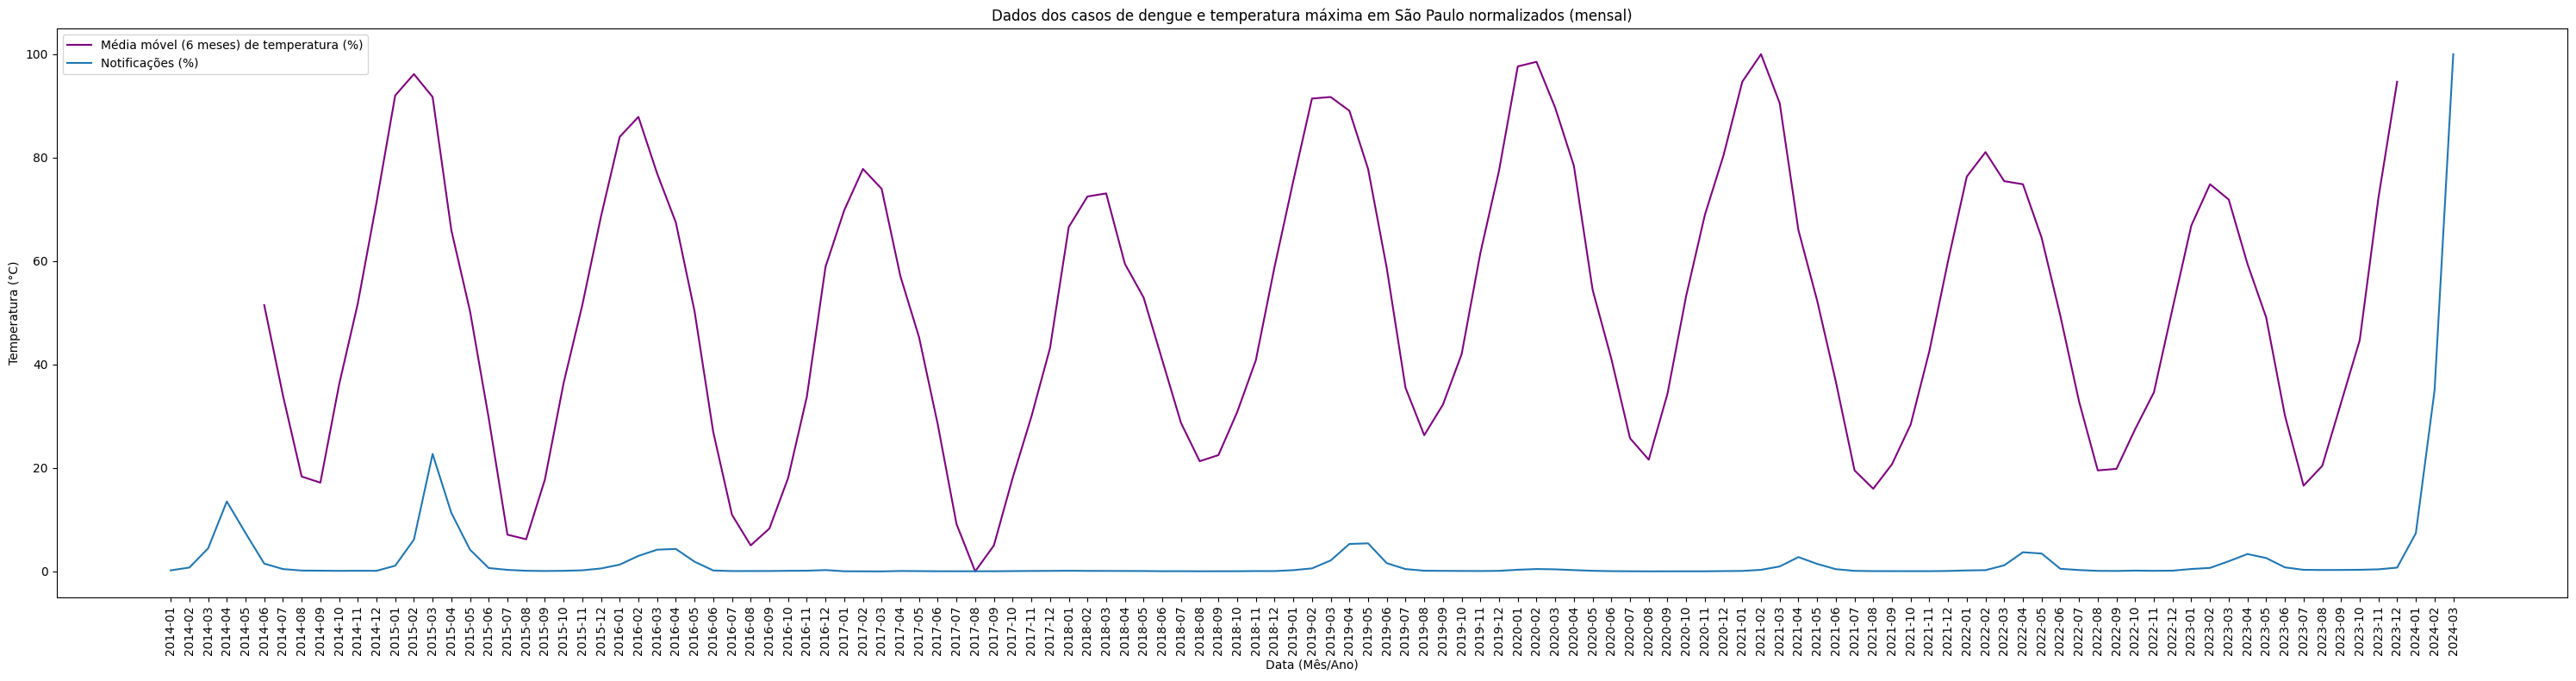

In [418]:
plt.figure(figsize=(30, 8))
plt.plot(inmetPlotDF['data'].astype(str), inmetPlotDF['normalized_moving_avg'], color='purple', label='Média móvel (6 meses) de temperatura (%)')
plt.plot((df_pivoted['month_year'].dt.to_period('M')).astype(str), df_pivoted['cases_normalized'], label='Notificações (%)')
plt.xticks(rotation=90)
plt.xlabel('Data (Mês/Ano)')
plt.ylabel('Temperatura (°C)')
plt.title('Dados dos casos de dengue e temperatura máxima em São Paulo normalizados (mensal)')
plt.legend()
plt.tight_layout()
plt.show()